### script to apply SSK BO over a locally constrained space
### we demonstrate on the task of finding proteins with low minimal free-folding energy

In [1]:
import numpy as np
import emukit
import re
from subprocess import Popen, PIPE
import subprocess
import matplotlib.pyplot as plt
from emukit.core.initial_designs import RandomDesign
from emukit.core import ParameterSpace
from emukit.core.optimization import RandomSearchAcquisitionOptimizer
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.core.loop import FixedIterationsStoppingCondition
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import our code
from boss.code.parameters.protein_base_parameter import ProteinBaseParameter
from boss.code.parameters.protein_codon_parameter import ProteinCodonParameter
from boss.code.optimizers.ProteinBaseGeneticAlgorithmAcquisitionOptimizer import ProteinBaseGeneticProgrammingOptimizer
from boss.code.optimizers.ProteinCodonGeneticAlgorithmAcquisitionOptimizer import ProteinCodonGeneticProgrammingOptimizer

from boss.code.emukit_models.emukit_bow_model import BOW_model
from boss.code.emukit_models.emukit_linear_model import linear_model
from boss.code.emukit_models.emukit_ssk_model import SSK_model
from boss.code.emukit_models.emukit_bio_features_model import BIO_Features_model

# Define problem (objective and space)

In [3]:
# define search space (a short protein to demo software)
length = 30
alphabet = ["a","c","t","g"]
space_codon = ParameterSpace([ProteinCodonParameter("string",sequence="TIKENIFGVS")])
space_base = ParameterSpace([ProteinBaseParameter("string",sequence="TIKENIFGVS")])
# protein consists of 10 amino acids (i.e 30 bases)

# define objective function (for base representations)
def objective_base(x):
    # x in 2-d numpy array of strings x =np.array([["actgg"],["gcttag"]])
    results = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        # call vienna RNA package
        # install binaries from https://www.tbi.univie.ac.at/RNA/
        p = subprocess.Popen('RNAfold', stdin=PIPE, stdout=PIPE) 
        string = "".join(x[i][0].split(" "))
        ans=p.communicate(string.encode())
        p.terminate()
        # collect results from output stream
        results[i][0] = float(str(ans[0]).split("(")[-1].split(")")[0])
    return results

# define objective function (for codon representations)
def objective_codon(x):
   	# x in 2-d numpy array of strings x =np.array([["'35 61 51 24 59 13 20 52 15 17'"]])    results = np.zeros((x.shape[0],1))
    results = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        # convert back to bases
        string = x[i][0]
        string = "".join([space_codon.parameters[0].codon_to_bases[c] for c in string.split(" ")])
        p = subprocess.Popen('RNAfold', stdin=PIPE, stdout=PIPE) 
        ans=p.communicate(string.encode())
        p.terminate()
        # collect results from output stream
        results[i][0] = float(str(ans[0]).split("(")[-1].split(")")[0])
    return results

In [4]:
# base representation is a locally constrained space of length 30 and alphabet size 4
# codon representation is a locally constrained space of length 10 and alphabet size 64

# examine sample data
print("example base representation: {}".format("".join(space_base.parameters[0].sample_uniform(1)[0][0].split(" "))))
print("example codon representation: {}".format(space_codon.parameters[0].sample_uniform(1)[0][0]))

example base representation: accatcaaagaaaacatattcggcgtgtct
example codon representation: 37 32 43 58 41 33 0 62 50 44


# Explain Methods

In [5]:
# We now demonstrate how to run all the methods described in Moss et al. 2020
#1) Linear GP applied to one-hot encoding of genes in their base representations) (i.e Taneka et al 2018)
#2) RBF GP applied to BOW representation of genes  in their base representations
#3) RBF GP applied to BOW representation of genes (+ some biologically-inspired features) in their 
#       codon representations (i.e Gonzalez et al. 2016)
#4) Our SSK approach applied to genes in their base representations
#5) Our SSK approach applied to genes in their codon representations
#6) Our split SSK approach applied to genes in their base representations
#7) Our split SSK approach applied to genes in their codon representations
#8) A purely randomized gene design loop

# Collect initial points

In [6]:
# collect initial design and initialize the search space (for both representations)
np.random.seed(42)
initial_points_count = 5

np.random.seed(42)
random_design_codon = RandomDesign(space_codon)
X_init_codon = random_design_codon.get_samples(initial_points_count)
np.random.seed(42)
random_design_base = RandomDesign(space_base)
X_init_base = random_design_base.get_samples(initial_points_count)
Y_init = objective_base(X_init_base)



# 1) Linear GP 

In [7]:
# build BO loop
# fit BOW model
model = linear_model(space_base,X_init_base,Y_init)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinBaseGeneticProgrammingOptimizer(space_base,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_linear = BayesianOptimizationLoop(model = model, 
                                         space = space_base,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
# add loop summary
def summary(loop, loop_state):
    print("Performing BO step {}".format(loop.loop_state.iteration))
bayesopt_loop_linear.iteration_end_event.append(summary)

Optimization restart 1/1, f = 9.386233715548721


In [8]:
np.random.seed(42)
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_linear.run_loop(objective_base, stopping_condition)

Optimization restart 1/1, f = 9.386233715548721
Performing BO step 1
Optimization restart 1/1, f = 11.39476338250529
Performing BO step 2
Optimization restart 1/1, f = 11.902867925628946
Performing BO step 3
Optimization restart 1/1, f = 13.722787563893545
Performing BO step 4
Optimization restart 1/1, f = 13.696552909452144
Performing BO step 5
Optimization restart 1/1, f = 13.134150458098407
Performing BO step 6
Optimization restart 1/1, f = 12.760782892854383
Performing BO step 7
Optimization restart 1/1, f = 16.951426639135043
Performing BO step 8
Optimization restart 1/1, f = 19.56638139095619
Performing BO step 9
Optimization restart 1/1, f = 20.75653668799771
Performing BO step 10
Optimization restart 1/1, f = 25.033021115903715


# 2) BOW of bases

In [9]:
# build BO loop
# fit BOW model
model = BOW_model(space_base,X_init_base,Y_init,max_feature_length=5)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinBaseGeneticProgrammingOptimizer(space_base,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_BOW = BayesianOptimizationLoop(model = model, 
                                         space = space_base,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
bayesopt_loop_BOW.iteration_end_event.append(summary)

Optimization restart 1/1, f = 7.094692902184848


In [10]:
np.random.seed(42)
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_BOW.run_loop(objective_base, stopping_condition)

Optimization restart 1/1, f = 7.094692902184848
Performing BO step 1
Optimization restart 1/1, f = 7.807354037809734
Performing BO step 2
Optimization restart 1/1, f = 9.932569732459173
Performing BO step 3
Optimization restart 1/1, f = 11.351508265667626
Performing BO step 4
Optimization restart 1/1, f = 12.77044679884241
Performing BO step 5
Optimization restart 1/1, f = 14.18938533204712
Performing BO step 6
Optimization restart 1/1, f = 15.608323865251833
Performing BO step 7
Optimization restart 1/1, f = 17.02726239845655
Performing BO step 8
Optimization restart 1/1, f = 18.44620093166126
Performing BO step 9
Optimization restart 1/1, f = 19.865139464865972
Performing BO step 10
Optimization restart 1/1, f = 21.284077998070686


# 3) BOW of codons + biollogically inspired features

In [11]:
# build BO loop
# fit model
model = BIO_Features_model(space_base,X_init_base,Y_init,max_feature_length=5)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinBaseGeneticProgrammingOptimizer(space_base,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_BIO = BayesianOptimizationLoop(model = model, 
                                         space = space_base,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
bayesopt_loop_BIO.iteration_end_event.append(summary)

Optimization restart 1/1, f = 7.094692674813557


In [12]:
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_BIO.run_loop(objective_base, stopping_condition)

Optimization restart 1/1, f = 7.094692674813557
Performing BO step 1
Optimization restart 1/1, f = 8.513631199228353
Performing BO step 2
Optimization restart 1/1, f = 9.932569732433079
Performing BO step 3
Optimization restart 1/1, f = 11.351508265637799
Performing BO step 4
Optimization restart 1/1, f = 12.77044679884252
Performing BO step 5
Optimization restart 1/1, f = 14.18938533204723
Performing BO step 6
Optimization restart 1/1, f = 15.608323865251954
Performing BO step 7
Optimization restart 1/1, f = 17.027262398456678
Performing BO step 8
Optimization restart 1/1, f = 18.446200931661394
Performing BO step 9
Optimization restart 1/1, f = 19.865139464866132
Performing BO step 10
Optimization restart 1/1, f = 21.28407799807086


# 4) SSK applied to base representations

In [13]:
# build BO loop
# fit SSK model
model = SSK_model(space_base,X_init_base,Y_init,max_subsequence_length=5)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinBaseGeneticProgrammingOptimizer(space_base,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_SSK_base= BayesianOptimizationLoop(model = model, 
                                         space = space_base,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
bayesopt_loop_SSK_base.iteration_end_event.append(summary)

reconstraining parameters GP_regression.sk.Gap_decay
reconstraining parameters GP_regression.sk.Match_decay


In [14]:
np.random.seed(42)
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_SSK_base.run_loop(objective_base, stopping_condition)

Optimization restart 1/3, f = 16.891289062554996
Optimization restart 2/3, f = 16.89129368114157
Optimization restart 3/3, f = 16.891288827030028
Performing BO step 1
Optimization restart 1/3, f = 12.84712888639276
Optimization restart 2/3, f = 12.847130466946714
Optimization restart 3/3, f = 12.8471249278725
Performing BO step 2
Optimization restart 1/3, f = 10.114646231499993
Optimization restart 2/3, f = 10.11465062234591
Optimization restart 3/3, f = 10.1146532191346
Performing BO step 3
Optimization restart 1/3, f = 8.84434739036907
Optimization restart 2/3, f = 8.844352474917223
Optimization restart 3/3, f = 8.844347398742778
Performing BO step 4
Optimization restart 1/3, f = 9.116141610274395
Optimization restart 2/3, f = 9.116141642357565
Optimization restart 3/3, f = 9.116141628389588
Performing BO step 5
Optimization restart 1/3, f = 9.457017507800904
Optimization restart 2/3, f = 9.457021153705833
Optimization restart 3/3, f = 9.457017693184056
Performing BO step 6
Optimizat

# 5) SSK applied to codon representations

In [15]:
# build BO loop
# fit SSK model
model = SSK_model(space_codon,X_init_codon,Y_init,max_subsequence_length=5)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinCodonGeneticProgrammingOptimizer(space_codon,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_SSK_codon= BayesianOptimizationLoop(model = model, 
                                         space = space_codon,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
bayesopt_loop_SSK_codon.iteration_end_event.append(summary)

reconstraining parameters GP_regression.sk.Gap_decay
reconstraining parameters GP_regression.sk.Match_decay


In [16]:
np.random.seed(42)
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_SSK_codon.run_loop(objective_codon, stopping_condition)

Optimization restart 1/3, f = 7.276460015889786
Optimization restart 2/3, f = 7.276461724256364
Optimization restart 3/3, f = 7.276471351257118
Performing BO step 1
Optimization restart 1/3, f = 8.038692872980997
Optimization restart 2/3, f = 8.038698016008011
Optimization restart 3/3, f = 8.038699132669082
Performing BO step 2
Optimization restart 1/3, f = 9.473403710977937
Optimization restart 2/3, f = 9.515876643155767
Optimization restart 3/3, f = 9.515873613120323
Performing BO step 3
Optimization restart 1/3, f = 10.06201973434613
Optimization restart 2/3, f = 9.115803536166176
Optimization restart 3/3, f = 9.115805062464979
Performing BO step 4
Optimization restart 1/3, f = 11.456303576828955
Optimization restart 2/3, f = 11.410319081899557
Optimization restart 3/3, f = 11.410319170491135
Performing BO step 5
Optimization restart 1/3, f = 11.453119933970306
Optimization restart 2/3, f = 11.453119421913247
Optimization restart 3/3, f = 11.453119219494937
Performing BO step 6
Opti

# 6) SSK applied to base representations split into 6


In [17]:
# build BO loop
# fit SSK model
model = SSK_model(space_base,X_init_base,Y_init,num_splits=6,max_subsequence_length=5)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinBaseGeneticProgrammingOptimizer(space_base,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_SSK_base_split= BayesianOptimizationLoop(model = model, 
                                         space = space_base,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
bayesopt_loop_SSK_base_split.iteration_end_event.append(summary)

reconstraining parameters GP_regression.sk.Gap_decay
reconstraining parameters GP_regression.sk.Match_decay


In [18]:
np.random.seed(42)
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_SSK_base_split.run_loop(objective_base, stopping_condition)

Optimization restart 1/3, f = 8.747444226983077
Optimization restart 2/3, f = 8.747451734764422
Optimization restart 3/3, f = 8.747447115758355
Performing BO step 1
Optimization restart 1/3, f = 10.018967606251977
Optimization restart 2/3, f = 10.018968300055008
Optimization restart 3/3, f = 10.01896766390808
Performing BO step 2
Optimization restart 1/3, f = 10.154447310709244
Optimization restart 2/3, f = 10.154451943432363
Optimization restart 3/3, f = 10.154453150603656
Performing BO step 3
Optimization restart 1/3, f = 10.518539121314667
Optimization restart 2/3, f = 10.518600629165107
Optimization restart 3/3, f = 10.51854248406548
Performing BO step 4
Optimization restart 1/3, f = 14.387406388428156
Optimization restart 2/3, f = 13.952619487175959
Optimization restart 3/3, f = 13.952619536298144
Performing BO step 5
Optimization restart 1/3, f = 17.891201008086313
Optimization restart 2/3, f = 17.87547661164786
Optimization restart 3/3, f = 17.875479308444795
Performing BO step 

# 7) SSK applied to codon representations split into 2


In [19]:
# build BO loop
# fit SSK model
model = SSK_model(space_codon,X_init_codon,Y_init,num_splits=2,max_subsequence_length=5)
# Load core elements for Bayesian optimization
expected_improvement = ExpectedImprovement(model)
# either use genetic algorithm or random search to optimize acqusition function
optimizer =  ProteinCodonGeneticProgrammingOptimizer(space_codon,dynamic=True,population_size=100,tournament_prob=0.5,p_crossover= 0.8, p_mutation=0.1)
# optimizer = RandomSearchAcquisitionOptimizer(space,10000)
bayesopt_loop_SSK_codon_split= BayesianOptimizationLoop(model = model, 
                                         space = space_codon,
                                         acquisition = expected_improvement,
                                         acquisition_optimizer = optimizer)
bayesopt_loop_SSK_codon_split.iteration_end_event.append(summary)

reconstraining parameters GP_regression.sk.Gap_decay
reconstraining parameters GP_regression.sk.Match_decay


In [20]:
np.random.seed(42)
# run BO loop for 10 steps 
stopping_condition = FixedIterationsStoppingCondition(i_max = 10) 
bayesopt_loop_SSK_codon_split.run_loop(objective_codon, stopping_condition)

Optimization restart 1/3, f = 8.05089644609358
Optimization restart 2/3, f = 8.050905500751588
Optimization restart 3/3, f = 8.050902634221202
Performing BO step 1
Optimization restart 1/3, f = 8.916839864872802
Optimization restart 2/3, f = 8.91683354377258
Optimization restart 3/3, f = 8.916833641342366
Performing BO step 2
Optimization restart 1/3, f = 12.173709991276318
Optimization restart 2/3, f = 12.14575157336915
Optimization restart 3/3, f = 12.145761301022443
Performing BO step 3
Optimization restart 1/3, f = 15.325525805389375
Optimization restart 2/3, f = 15.325525642265601
Optimization restart 3/3, f = 15.325525826451123
Performing BO step 4
Optimization restart 1/3, f = 14.02636115303856
Optimization restart 2/3, f = 14.026365564976922
Optimization restart 3/3, f = 14.026366620723405
Performing BO step 5
Optimization restart 1/3, f = 13.753686513670466
Optimization restart 2/3, f = 13.662136298659437
Optimization restart 3/3, f = 13.662137529020894
Performing BO step 6
Op

# 8) Perform random search

In [21]:
np.random.seed(42)
# also see performance of random search 
#(starting from the initialization used by the other approaches)
Y_random=np.vstack([Y_init,objective_base(random_design_base.get_samples(10))])

# plot results

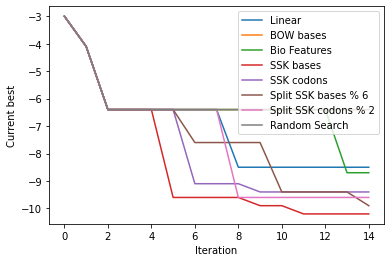

In [22]:
# recall that first 5 points are a random sample shared by all the methods
# must run over multiple seeds to get an reliable idea of which algorithm is more efficient
plt.plot(np.minimum.accumulate(bayesopt_loop_linear.loop_state.Y),label="Linear")
plt.plot(np.minimum.accumulate(bayesopt_loop_BOW.loop_state.Y),label="BOW bases")
plt.plot(np.minimum.accumulate(bayesopt_loop_BIO.loop_state.Y),label="Bio Features")

plt.plot(np.minimum.accumulate(bayesopt_loop_SSK_base.loop_state.Y),label="SSK bases")
plt.plot(np.minimum.accumulate(bayesopt_loop_SSK_codon.loop_state.Y),label="SSK codons")
plt.plot(np.minimum.accumulate(bayesopt_loop_SSK_base_split.loop_state.Y),label="Split SSK bases % 6")
plt.plot(np.minimum.accumulate(bayesopt_loop_SSK_codon_split.loop_state.Y),label="Split SSK codons % 2")

plt.plot(np.minimum.accumulate(Y_random),label="Random Search")

plt.ylabel('Current best')
plt.xlabel('Iteration')
plt.legend()